#  Project

***@Author: Zerui HUANG***  
      
***Email Address***   
zerui_huang@u.nus.edu

## 1. Replication of A Call Option

**General introduction**:   
    
In this project, I replicated a call option with two methods, ***binomial tree*** method and ***Black-Scholes*** method. I used function **crr** for calculation of historical volatility and used function **Greeks** for calculation of BS delta, which is used in construction of the replicted portfolio.
    
To evaluate the effect of the replication. I use the historical data of ***50ETF*** and option contract ***10001677.XSHG***. To acquire more samples of replication, I back tested through the trading date of the option, which was traded between ***2019/1/24-2019/9/25***. I used the ***close*** price for calculation and treated every day as a start for a 14 day's replication. To exclude the irregular fluctuation of ***liquidity risk***,I dropped the beginning and the end and used data ***2019/1/31-2019/8/26***. I also defined ***a ratio to evaluate the deviation of change of portfolio value from the real change of value of call option***.   

For demonstration, we discribed the distribution of ratio. ***From the result we could tell, only use delta for replication, was not a perfect method, there would be deviations, using both BS method and binomial method.*** 

There exists deficits in this replication. Eg, to demonstrate the effect, I could see that the mathemetical average were 0.28, which means 28% deviation from the real change of value. ***However, if we used the amount of absolute value change as weight and then take weighted average, the result maybe better since some extreme percentage change comes from a ratetively smaller change of call option as denominator.*** 

**Data**: Download from jointquant  
**Method**: by comparing binomial and bs-delta to calculate delta  
**Period**: 14 nature days  
**Timeline**: rolling back testing for a continuous period

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import *
import datetime
from datetime import timedelta
from scipy.stats import norm
import jqdatasdk as jq
jq.auth("17863032396","sw123456")

Define function ***crr*** to get volatility, ***sigma***, of the underlying from historical data, and then calculate ***u*** and ***d***.   
Define function ***Greeks*** to calculate ***delta*** with ***bs*** method.         
Define function ***repli*** to get ***delta*** with both ***binomial*** method and ***bs*** method, and to get ***c0*** and ***b0***. ***c0*** is the money I get from selling 1 unit of the option at ***t0***, ***b0*** is the part of money we put into currency market.

In [5]:
def crr(df, start, num, rtc): 
    inter = df.loc[:start,:].iloc[:-1,:]
    stdlgr = inter.log_ret.iloc[-num:].std()
    sigma = stdlgr * (252)**0.5; u = np.exp(sigma * sqrt(rtc/365)); d = 1/u
    return sigma, u, d

def Greeks(S,K,T,r,iv,flag):
    d1 = (log(S / K) + (r+ iv * iv / 2) * T) / (iv * sqrt(T))
    d2 = d1 - iv * sqrt(T)
    if (flag == 'c'or flag == 'C' or flag == '认购'or flag == '看涨'or flag == 'CO'):
        Delta = norm.cdf(d1)
    elif (flag == 'p'or flag == 'P' or flag == '认沽'or flag == '看跌' or flag == 'PO'):
        Delta = -norm.cdf(-d1)
    return Delta

def repli(s0, opt, start, rtc, u, d, k, units, mtd, sigma, flag):
    c0 = opt.loc[start,"close"]
    if mtd == "binomial":
        delta = (max(s0*u-k,0)-max(s0*d-k,0))/(s0*u-s0*d)
    elif mtd == "bs":
        delta = Greeks(s0,k,rtc/365,0.04,sigma,flag)
    b0 = c0 * units- s0 * int(delta * units)
    return delta, c0, b0

Due to the fact that I choose 14 natural days as a time period which actually cannot cover 14 trading days, we have to find the real date ***t1*** which is the end of 14 trading days by defining function ***ednf***.

In [6]:
def endf(df, start, tc, rtc):
    tryt = start + timedelta(days = 14)
    if tryt in df.index:
        return tryt, rtc
    else:
        time = [i for i in df.index if i > tryt]
        end = min(time)
        rtc = (end - start).days
        return end, rtc

Suppose that from ***t0*** to ***t1***, the change of the value of the option is ***dv*** and that of our portfolio is ***dr***. And ***dif = dr - dv***.   
The way I estimate the efficieny of our replication is to calculate the ratio of 
$$\frac{\left|dif\right|}{\left|dr\right|} \quad$$
Theoretically, the smaller this result is, the more efficient our replication would be, because of the consistent change of our portfolio and the option.

In [7]:
def efficiency(output):
    output["eff"] = np.nan
    for i in output.index:
        output.loc[i,"eff"] = abs(output.loc[i,"dif"])/abs(output.loc[i,"dr"])
    return output

Read data.

In [8]:
info = pd.read_excel(r"D:\projects\project_data\info.xlsx")
etf_day = pd.read_excel(r"D:\projects\project_data\etf_day.xlsx")
etf_day['log_ret'] = np.log(etf_day.close) - np.log(etf_day.close.shift(1))
etf_week=pd.read_excel(r"D:\projects\project_data\etf_week.xlsx")

Here, I represent the method by which I decided to choose contract ***10001677*** to do replication.  
Basically, it is a in-the-money call option with delist reason of "contract expired".

In [9]:
tb = pd.read_excel(r"D:\projects\project_data\info.xlsx")
tb = tb[tb["contract_type"]=="CO"]; tb = tb[tb["delist_reason"]=="合约到期"]
tb["last"] = tb["expire_date"] - tb["list_date"]

for i in tb.index:
    tb.loc[i,"s-k"] = etf_day.loc[tb.loc[i,"list_date"],"close"] - tb.loc[i,"exercise_price"]
tb = tb[tb["s-k"]>0]

In [10]:
num = "10001677"
opt = pd.read_excel(r"D:\projects\project_data\\" +num +".xlsx")
k = tb[tb['code']== num + ".XSHG"].iloc[0,11]
units = tb[tb['code']== num + ".XSHG"].iloc[0,12]

c_1677 = tb[tb["code"] == "10001677.XSHG"]
c_1677

,code,id,trading_code,name,contract_type,exchange_code,currency_id,underlying_symbol,underlying_name,underlying_exchange,...,low_limit,expire_date,last_trade_date,exercise_date,delivery_date,is_adjust,delist_date,delist_reason,last,s-k
1676,10001677.XSHG,11055,510050C1909M02200,50ETF购9月2200,CO,XSHG,CNY,510050.XSHG,50ETF,XSHG,...,0.0434,2019-09-25,2019-09-25,2019-09-25,2019-09-26,0,2019-09-26,合约到期,244 days,0.203


To exclude the irregular fluctuation of ***liquidity risk***, I pick the period between the date of seven natural days after list date and the date of 30 natural days before delist date, that is, ***2019/1/31-2019/8/26***.

In [11]:
sta = opt.index[0]+timedelta(days = 7); stn = list(opt.index).index(sta)
end = max(opt.index) - timedelta(days = 30); enn = list(opt.index).index(end)
sta,end

(Timestamp('2019-01-31 00:00:00'), Timestamp('2019-08-26 00:00:00'))

Assign values to parameters and start to calculate.

In [12]:
r = 0.03
n = 0; tc = 14; rtc = 14 #此处n = 0, n = locals() 是否可以删掉
n = locals()      
result = {}
method = ["binomial","bs"]

In [13]:
for mtd in method:
    output = pd.DataFrame(columns=["t0","t1", "opt", "k", "sigma", "u" ,"d", "s0","s1","delta", "c0","c1","b0","b1","v0","v1","dr","dv","dif","eff"],index = opt.index[stn:enn+1])
    for t0 in opt.index[stn:enn+1]:
        t1, rtc = endf(opt, t0, tc, rtc)
        s0 = etf_day.loc[t0,"close"]
        sigma, u, d = crr(etf_day, t0, 100, rtc)
        delta, c0, b0 = repli(s0, opt, t0, rtc, u, d, k, units, mtd, sigma, "c")
        v0 = c0 * units
        s1 = etf_day.loc[t1,"close"]; c1 = opt.loc[t1,"close"]; b1 = b0 * np.exp(r*rtc/365)
        v1 = s1 * int(delta * units) + b1

        dv = v1 - v0
        dr = (c1 - c0)* units

        output.loc[t0,"t0"] = t0
        output.loc[t0,"t1"] = t1
        output.loc[t0,"opt"] = num
        output.loc[t0,"k"] = k
        output.loc[t0,"sigma"] = sigma
        output.loc[t0,"u"] = u
        output.loc[t0,"d"] = d
        output.loc[t0,"s0"] = s0
        output.loc[t0,"s1"] = s1
        output.loc[t0,"delta"] = delta
        output.loc[t0,"c0"] = c0
        output.loc[t0,"c1"] = c1
        output.loc[t0,"b0"] = b0
        output.loc[t0,"b1"] = b1
        output.loc[t0,"v0"] = v0
        output.loc[t0,"v1"] = v1
        output.loc[t0,"dr"] = dr
        output.loc[t0,"dv"] = dv
        output.loc[t0,"dif"] = dr-dv
    output = efficiency(output)
    result[mtd] = output

I save our outputs of ***binomial*** method and ***bs*** method into a dictionary ***result***.  
Here is a short representation of these two outputs.

In [16]:
result["binomial"]

,t0,t1,opt,k,sigma,u,d,s0,s1,delta,c0,c1,b0,b1,v0,v1,dr,dv,dif,eff
2019-01-31,2019-01-31 00:00:00,2019-02-14 00:00:00,10001677,2.2,0.238137,1.04774,0.954432,2.474,2.567,1,0.3391,0.4325,-21349,-21373.6,3391,4296.42,934,905.42,28.5801,0.030600
2019-02-01,2019-02-01 00:00:00,2019-02-15 00:00:00,10001677,2.2,0.239286,1.04798,0.954218,2.492,2.511,1,0.3565,0.389,-21355,-21379.6,3565,3730.41,325,165.413,159.587,0.491037
2019-02-11,2019-02-11 00:00:00,2019-02-25 00:00:00,10001677,2.2,0.238382,1.04779,0.954387,2.516,2.816,1,0.376,0.6892,-21400,-21424.6,3760,6735.36,3132,2975.36,156.639,0.050012
2019-02-12,2019-02-12 00:00:00,2019-02-26 00:00:00,10001677,2.2,0.235547,1.04721,0.954917,2.524,2.728,1,0.381,0.6199,-21430,-21454.7,3810,5825.33,2389,2015.33,373.673,0.156414
2019-02-13,2019-02-13 00:00:00,2019-02-27 00:00:00,10001677,2.2,0.235149,1.04713,0.954991,2.571,2.736,1,0.4305,0.6323,-21405,-21429.6,4305,5930.36,2018,1625.36,392.645,0.194571
2019-02-14,2019-02-14 00:00:00,2019-02-28 00:00:00,10001677,2.2,0.236417,1.04739,0.954754,2.567,2.736,1,0.4325,0.622,-21345,-21369.6,4325,5990.42,1895,1665.42,229.576,0.121148
2019-02-15,2019-02-15 00:00:00,2019-03-01 00:00:00,10001677,2.2,0.235854,1.04727,0.954859,2.511,2.802,1,0.389,0.6862,-21220,-21244.4,3890,6775.57,2972,2885.57,86.4316,0.029082
2019-02-18,2019-02-18 00:00:00,2019-03-04 00:00:00,10001677,2.2,0.238283,1.04777,0.954405,2.571,2.815,1,0.4447,0.7005,-21263,-21287.5,4447,6862.52,2558,2415.52,142.481,0.055700
2019-02-19,2019-02-19 00:00:00,2019-03-05 00:00:00,10001677,2.2,0.240815,1.04829,0.953932,2.567,2.813,1,0.4481,0.6986,-21189,-21213.4,4481,6916.6,2505,2435.6,69.3959,0.027703
2019-02-20,2019-02-20 00:00:00,2019-03-06 00:00:00,10001677,2.2,0.239937,1.04811,0.954096,2.577,2.82,1,0.4553,0.7014,-21217,-21241.4,4553,6958.57,2461,2405.57,55.4281,0.022523


In [17]:
result["bs"]

,t0,t1,opt,k,sigma,u,d,s0,s1,delta,c0,c1,b0,b1,v0,v1,dr,dv,dif,eff
2019-01-31,2019-01-31 00:00:00,2019-02-14 00:00:00,10001677,2.2,0.238137,1.05274,0.949905,2.474,2.567,0.990509,0.3391,0.4325,-21114,-21143.5,3391,4282.64,934,891.643,42.3573,0.045350
2019-02-01,2019-02-01 00:00:00,2019-02-15 00:00:00,10001677,2.2,0.239286,1.053,0.94967,2.492,2.511,0.993343,0.3565,0.389,-21188,-21217.7,3565,3724.1,325,159.101,165.899,0.510458
2019-02-11,2019-02-11 00:00:00,2019-02-25 00:00:00,10001677,2.2,0.238382,1.05279,0.949855,2.516,2.816,0.996216,0.376,0.6892,-21304.4,-21334.2,3760,6718.81,3132,2958.81,173.189,0.055296
2019-02-12,2019-02-12 00:00:00,2019-02-26 00:00:00,10001677,2.2,0.235547,1.05215,0.950436,2.524,2.728,0.997152,0.381,0.6199,-21356.8,-21386.7,3810,5814.22,2389,2004.22,384.778,0.161062
2019-02-13,2019-02-13 00:00:00,2019-02-27 00:00:00,10001677,2.2,0.235149,1.05206,0.950518,2.571,2.736,0.999134,0.4305,0.6323,-21381.9,-21411.8,4305,5923.62,2018,1618.62,399.382,0.197910
2019-02-14,2019-02-14 00:00:00,2019-02-28 00:00:00,10001677,2.2,0.236417,1.05235,0.950258,2.567,2.736,0.998985,0.4325,0.622,-21316.8,-21346.6,4325,5983.34,1895,1658.34,236.665,0.124889
2019-02-15,2019-02-15 00:00:00,2019-03-01 00:00:00,10001677,2.2,0.235854,1.05222,0.950373,2.511,2.802,0.99609,0.389,0.6862,-21119.6,-21149.1,3890,6758.83,2972,2868.83,103.17,0.034714
2019-02-18,2019-02-18 00:00:00,2019-03-04 00:00:00,10001677,2.2,0.238283,1.05277,0.949875,2.571,2.815,0.999007,0.4447,0.7005,-21237.3,-21267,4447,6854.87,2558,2407.87,150.135,0.058692
2019-02-19,2019-02-19 00:00:00,2019-03-05 00:00:00,10001677,2.2,0.240815,1.05335,0.949356,2.567,2.813,0.998779,0.4481,0.6986,-21155.6,-21185.2,4481,6908.22,2505,2427.22,77.7786,0.031049
2019-02-20,2019-02-20 00:00:00,2019-03-06 00:00:00,10001677,2.2,0.239937,1.05315,0.949536,2.577,2.82,0.999085,0.4553,0.7014,-21191.2,-21220.9,4553,6950.94,2461,2397.94,63.0604,0.025624


I represent two ***histograms*** of two results on efficiency, and also give some statistical describe of out results.

Text(0.5, 1.0, 'binomial tree')

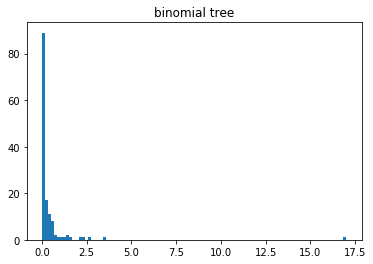

In [18]:
plt.hist(result["binomial"].eff,bins = 100)
plt.title("binomial tree")

In [19]:
result["binomial"].eff.describe()

count    138.000000
mean       0.408680
std        1.511109
min        0.002436
25%        0.050711
50%        0.115034
75%        0.271032
max       17.007105
Name: eff, dtype: float64

Text(0.5, 1.0, 'Black-Scholes')

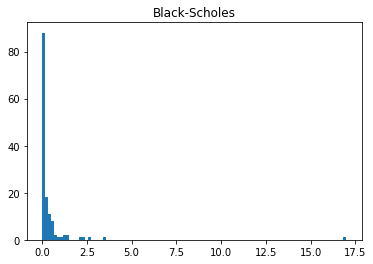

In [20]:
plt.hist(result["bs"].eff,bins = 100)
plt.title("Black-Scholes")

In [21]:
result["bs"].eff.describe()

count    138.000000
mean       0.405886
std        1.509101
min        0.002534
25%        0.050757
50%        0.115123
75%        0.269863
max       17.005076
Name: eff, dtype: float64

It is obvious that there exists an ***abnormal*** value of 17, so in order to improve the validity of our replication, I drop it.

Text(0.5, 1.0, 'binomial tree')

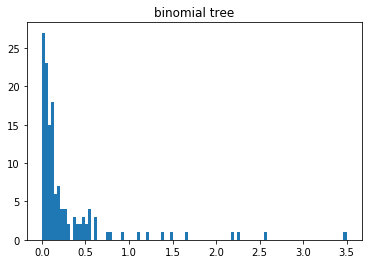

In [22]:
m1 = max(result["binomial"].eff)
output_bi = result["binomial"][result["binomial"]["eff"] < m1]
plt.hist(output_bi.eff,bins = 100)
plt.title("binomial tree")

In [24]:
output_bi.eff.describe()

count    137.000000
mean       0.287524
std        0.509569
min        0.002436
25%        0.050520
50%        0.112290
75%        0.266971
max        3.499422
Name: eff, dtype: float64

Text(0.5, 1.0, 'Black-Scholes')

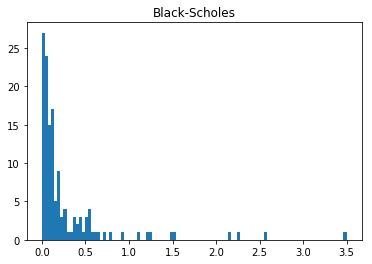

In [25]:
m2 = max(result["bs"].eff)
output_bs = result["bs"][result["bs"]["eff"] < m2]
plt.hist(output_bs.eff,bins = 100)
plt.title("Black-Scholes")

In [26]:
output_bs.eff.describe()

count    137.000000
mean       0.284724
std        0.503354
min        0.002534
25%        0.050616
50%        0.112380
75%        0.262073
max        3.499180
Name: eff, dtype: float64

## 2. Portfolio Insurance

***General description***  
In this project, I backtested by replicating put options. The result shows that the net_value logically coincide with the the theory. that is, ***the fluctuation of etf is more fierce than net_value. In other words, if ETF grows, it grows more than hedge result, and drops more than the hedged result when the ETF price goes down.***

Define function ***endf*** to find the real ***t1***.  
Define function ***dynamic*** to describe positon ratio of the part we invest in ETF50 and that in risk-free bond.
At the begining, I invest certain shares of 50ETF which means we need corresponding ***put options*** to limit downside risk.
Then we do ***replication*** of these put options.

In [80]:
def endf(df, start, tc, rtc, end):
    tryt = start + timedelta(days = tc)
    if tryt in df.index:
        return tryt, rtc
    else:
        time = [i for i in df.index if i > tryt]
        try:
            ed = min(time)
            rtc = (ed - start).days
            return ed, rtc
        except:
            return end, rtc
        
def dynamic(nv,st,delta):
    sln = int(nv/st)    # positon of 50ETF
    slv = sln * st
    ssn = int(sln * delta)  # short underlyings, ssn is negative
    ssv = ssn * st
    b0 = nv - slv - ssv # positon of risk-free bond
    return sln, slv, ssn, ssv, b0

Choose a period.

In [81]:
sta = etf_day.index[300]; stn = list(etf_day.index).index(sta)
end = max(etf_day.index); enn = list(etf_day.index).index(end)
sta,end

(Timestamp('2016-03-29 00:00:00'), Timestamp('2019-11-01 00:00:00'))

In [82]:
r = 0.03
n = 0; tc = 1; rtc = 1
nv = 1000000
s0 = etf_day.loc[sta,"close"]; st = 0; delta = 0; b0 = 0

re = pd.DataFrame(columns=["nv","etf","sln", "slv", "ssv", "sigma","delta", "b0","t1"],index = etf_day.index[stn:])

for t0 in etf_day.index[stn:enn+1]:
    
    # calculate the change of net value
    st = etf_day.loc[t0,"close"]
    cnv = sln * (st - s0) + ssn * (st - s0) + b0 * (np.exp(r*((t1-t0).days)/365)-1)
    nv = cnv + nv
    
    # calculate today's position
    t1, rtc = endf(etf_day, t0, tc, rtc,end)
    sigma,u,d = crr(etf_day, t0, 100, rtc)
    delta = Greeks(st,0.9*st,0.5,r,sigma,"p")
    sln, slv, ssn, ssv, b0 = dynamic(nv,st,delta)
    sln = sln + ssn 
    
    # daily record
    re.loc[t0,"cnv"] =cnv
    re.loc[t0,"nv"] = nv
    re.loc[t0,"etf"] = st
    re.loc[t0,"t1"] = t1
    re.loc[t0,"sln"] = sln
    re.loc[t0,"slv"] = slv
    re.loc[t0,"delta"] = delta
    re.loc[t0,"ssv"] = ssv
    re.loc[t0,"ssn"] = ssn
    re.loc[t0,"b0"] = b0
    re.loc[t0,"sigma"] = sigma

    s0 = st

In [83]:
re.iloc[:,:]

,nv,etf,sln,slv,ssv,sigma,delta,b0,t1,cnv,ssn
2016-03-29,1e+06,1.982,372712,999998,-261283,0.324407,-0.261284,261285,2016-03-30 00:00:00,0.000,-131828.0
2016-03-30,1.01229e+06,2.033,367885,1.01228e+06,-264373,0.324119,-0.261166,264375,2016-03-31 00:00:00,12285.084,-130041.0
2016-03-31,1.01181e+06,2.031,367547,1.01181e+06,-265320,0.326715,-0.262225,265321,2016-04-01 00:00:00,-475.688,-130635.0
2016-04-01,1.0137e+06,2.039,368811,1.0137e+06,-261697,0.317006,-0.258161,261699,2016-04-05 00:00:00,1895.296,-128346.0
2016-04-05,1.01611e+06,2.049,368438,1.01611e+06,-261178,0.31444,-0.257039,261180,2016-04-06 00:00:00,2404.650,-127466.0
2016-04-06,1.0137e+06,2.039,369816,1.0137e+06,-259644,0.312409,-0.256137,259645,2016-04-07 00:00:00,-2409.720,-127339.0
2016-04-07,1.00788e+06,2.015,372255,1.00788e+06,-257785,0.311591,-0.25577,257786,2016-04-08 00:00:00,-5819.448,-127933.0
2016-04-08,1.00446e+06,2.001,373497,1.00446e+06,-257090,0.311991,-0.25595,257092,2016-04-11 00:00:00,-3420.508,-128481.0
2016-04-11,1.00887e+06,2.019,371791,1.00887e+06,-258222,0.312,-0.255954,258224,2016-04-12 00:00:00,4410.288,-127896.0
2016-04-12,1.00863e+06,2.018,371929,1.00862e+06,-258072,0.311806,-0.255866,258073,2016-04-13 00:00:00,-243.895,-127885.0


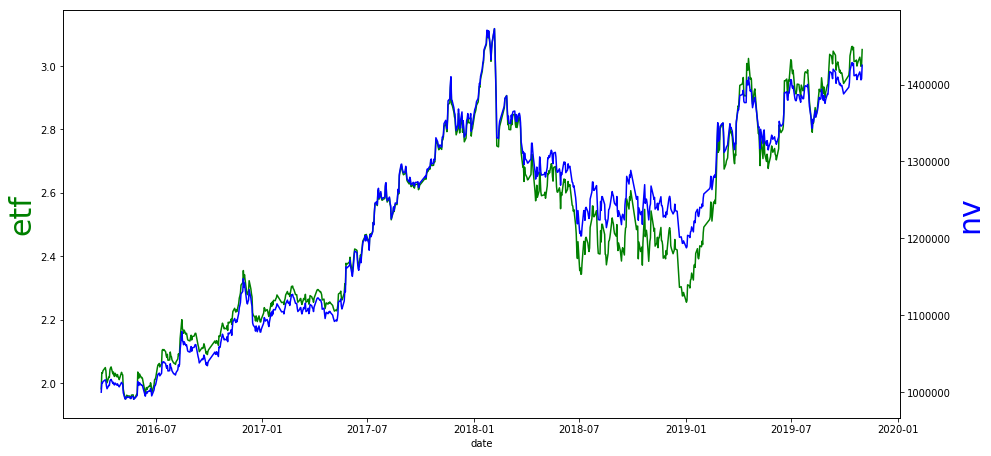

In [84]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 7.5) # 设置figure_size尺寸
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x,np.array(re.etf),'g-')
ax2.plot(x,np.array(re.nv),'b-')
 
ax1.set_xlabel("date")
ax1.set_ylabel("etf",color='g', fontsize = 30)
 
ax2.set_ylabel("nv",color='b',fontsize = 30)
 
plt.show()